In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv


# Introduction

## Import Libraries

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score

import warnings 
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import Data

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e3/train.csv',index_col=0)
test_df = pd.read_csv('/kaggle/input/playground-series-s3e3/test.csv',index_col=0)

df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
id,,,,,,,,,,,,,,,,,,,,,
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,80,0,31,0,3,31,14,4,10,1


## Explore Data

In [4]:
# check training dataset size
print('Number of Examples: ' + str(df.shape[0]))
print('Number of Features: ' + str(df.shape[1]))
print('Number of Categorical Features: ' + str(df.select_dtypes('object').shape[1]))
print('Number of Numerical Features: ' + str(df.select_dtypes('number').shape[1]-1)) # one of the numerical columns is a target column

Number of Examples: 1677
Number of Features: 34
Number of Categorical Features: 8
Number of Numerical Features: 25


-> **overfitting risk**: the number of examples is small but the number of features is large.<br>

In [5]:
# check number of null values
df.isnull().sum()

Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
Attrition 

In [6]:
test_df.isnull().sum()

Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int

-> **no null values** found across all columns

[Text(0, 0, '1477'), Text(0, 0, '200')]

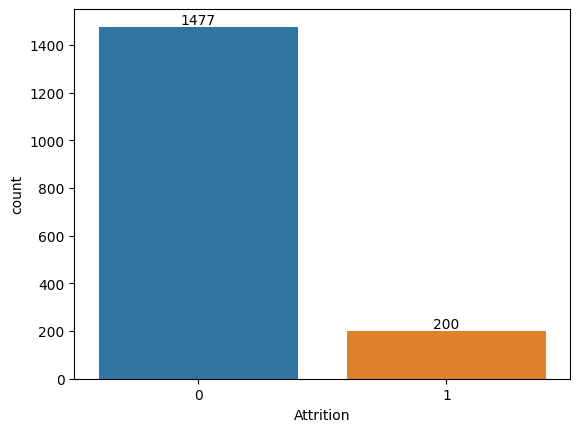

In [7]:
ax = sns.countplot(data=df,x='Attrition')
ax.bar_label(ax.containers[0])

In [8]:
df['Attrition'].value_counts(normalize=True)

0    0.880739
1    0.119261
Name: Attrition, dtype: float64

-> **class imbalance**: over 88% of the examples are labeled class 0.

## Numerical Features

In [9]:
# creat a dataframe containing only numerical columns from the original dataframe
df_num = df.select_dtypes('number').drop('Attrition',axis=1)
df_num.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [10]:
# explore numerical values - 1
describe = df_num.describe()
describe.iloc[:,:13]

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,2.791890,6196.049493,14770.048301,2.574836
std,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,1.097396,4520.050754,7112.203888,2.480215
min,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,1.000000,1010.000000,636.000000,0.000000
25%,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,2.000000,2875.000000,8509.000000,1.000000
50%,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,3.000000,4834.000000,15332.000000,1.000000
75%,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,4.000000,7403.000000,20990.000000,4.000000
max,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,4.000000,19973.000000,26999.000000,9.000000


In [11]:
# explore numerical values - 2
describe.iloc[:,13:]

,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,14.903399,3.127609,2.751342,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643
std,3.420801,0.333753,1.077905,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189
min,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,14.000000,3.000000,3.000000,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,17.000000,3.000000,4.000000,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000
max,25.000000,4.000000,4.000000,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000


In [12]:
print('Columns that contain only one value: ' +str(list(describe.loc[:,describe.loc['std',:]==0].columns)))

Columns that contain only one value: ['EmployeeCount', 'StandardHours']


-> **unnecesary numerical columns**: two columns contain only one value across all examples

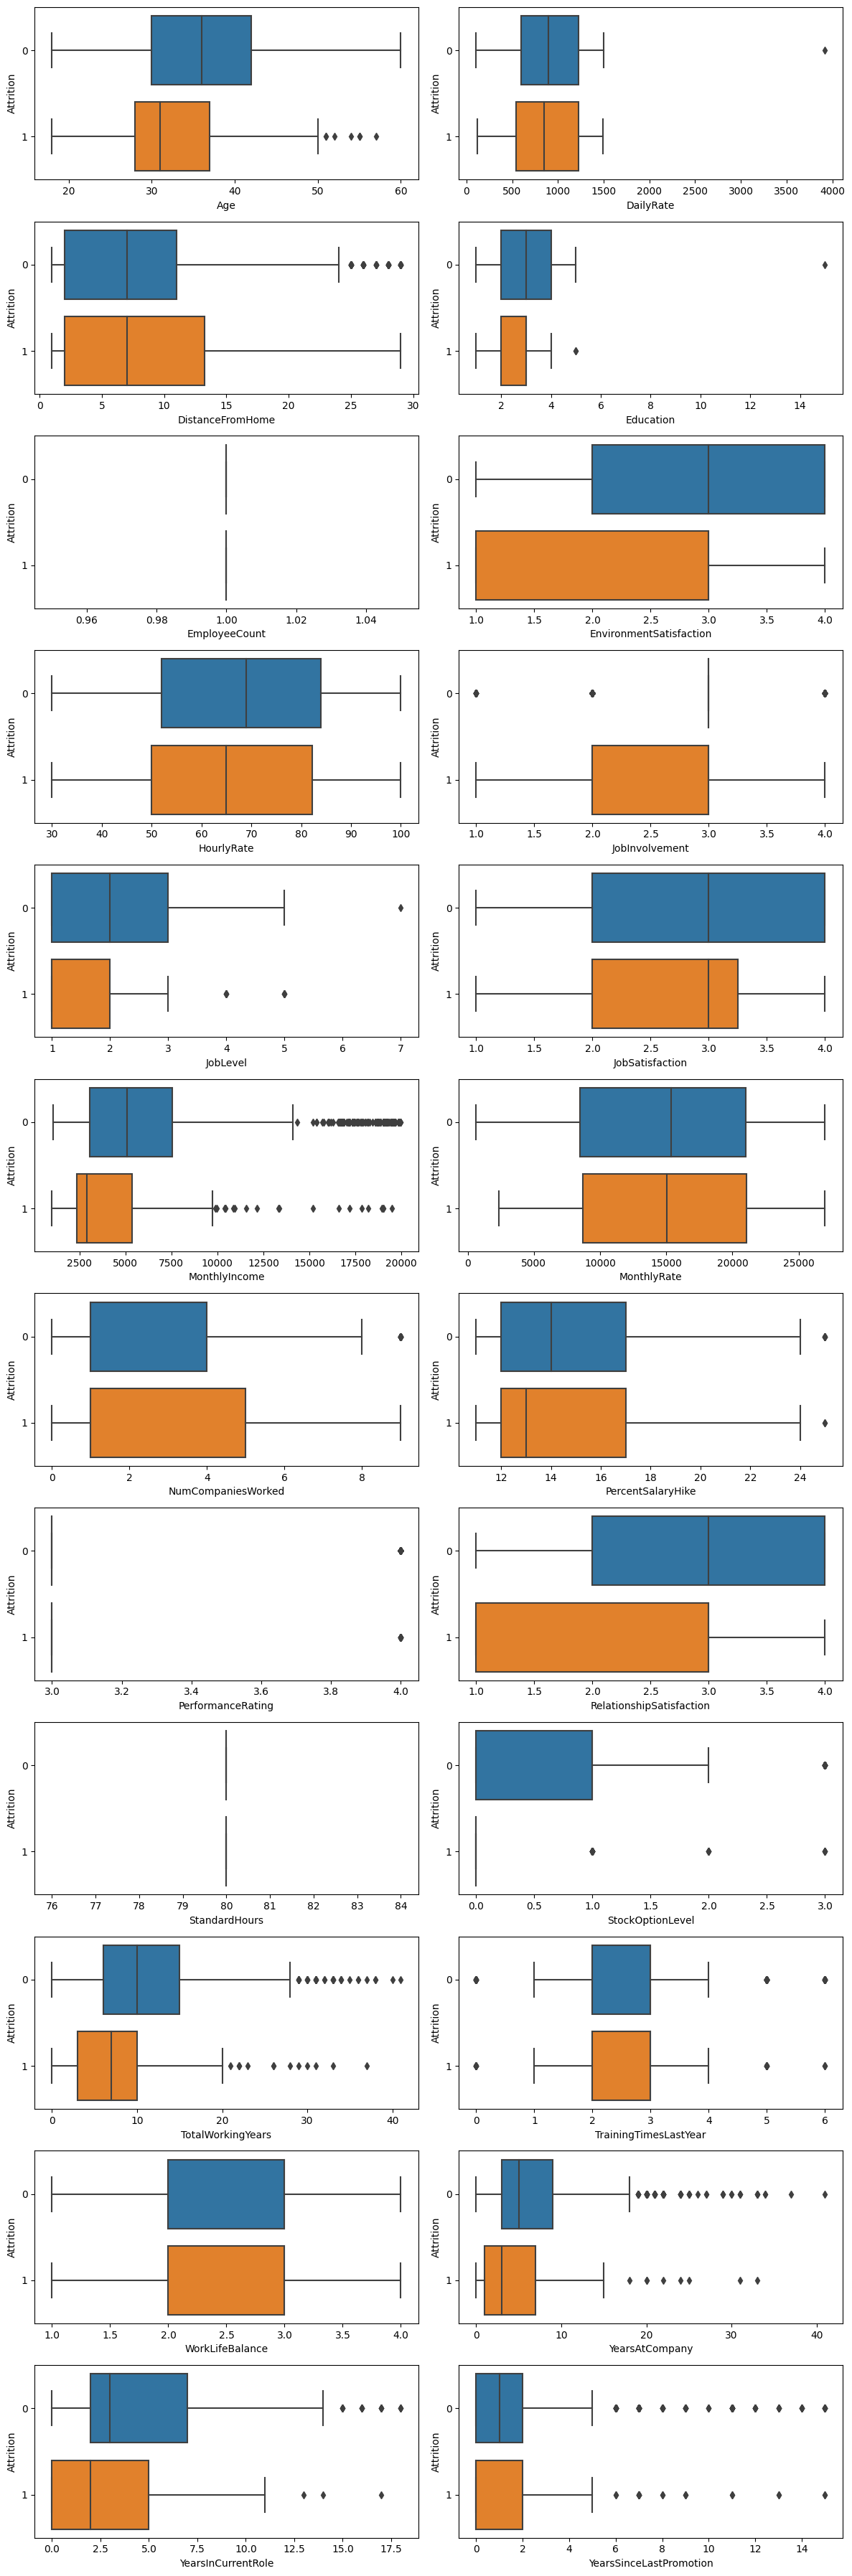

In [13]:
# visualize distribution of values in numerical columns group by Attrition
ncols = 2
nrows = round(len(df_num.columns) / ncols)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,nrows*3))
for col, ax in zip(df_num.columns, axs.flatten()):
    sns.boxplot(data=pd.concat([df_num,df['Attrition'].astype('category')],axis=1),y='Attrition',x=col, ax=ax)

plt.tight_layout()

In [14]:
# check outliers
outlier_col = []
for col in df_num:
    if df_num[(np.abs(stats.zscore(df_num[col])) > 5)][col].shape[0] > 0:
        print(df_num[(np.abs(stats.zscore(df_num[col])) > 5)][col])
        outlier_col.append(col)

print('')
print('Columns that contain outliers: ' + str(outlier_col))

id
1398    3921
Name: DailyRate, dtype: int64
id
527    15
Name: Education, dtype: int64
id
713    37
877    41
Name: YearsAtCompany, dtype: int64

Columns that contain outliers: ['DailyRate', 'Education', 'YearsAtCompany']


<AxesSubplot: >

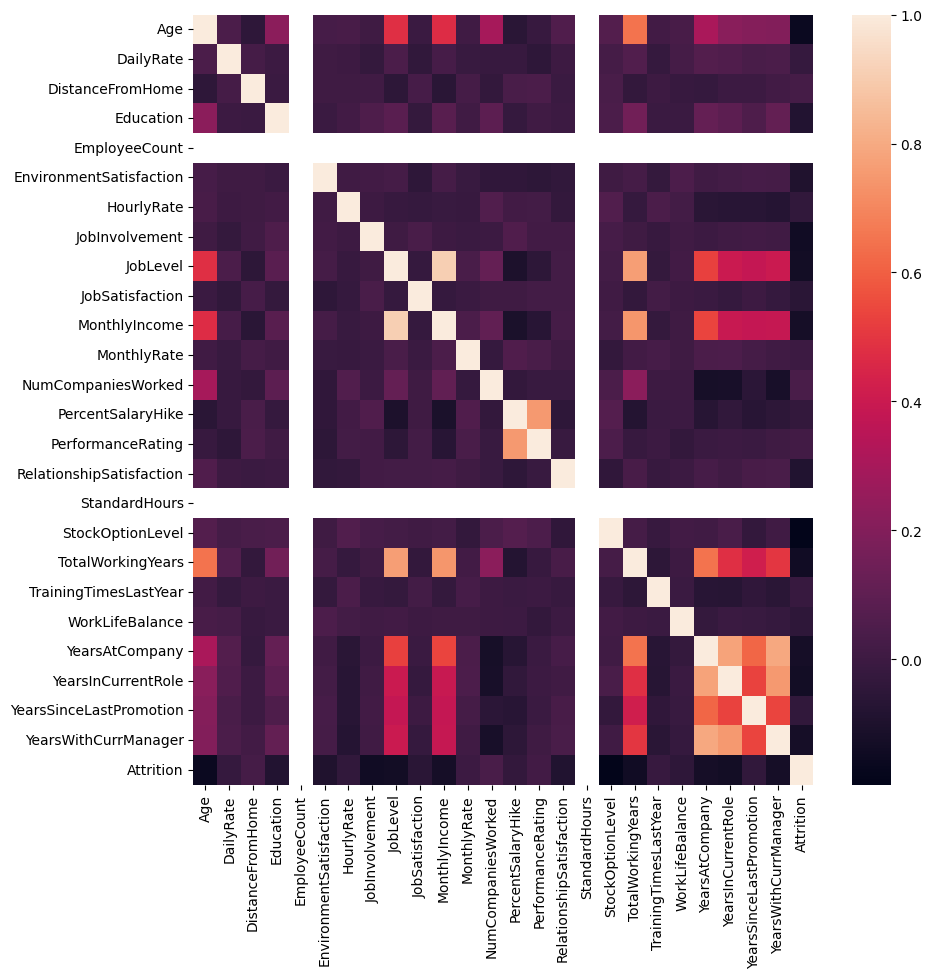

In [15]:
# explore correlation between columns
correlations = pd.concat([df_num,df['Attrition']],axis=1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlations)

In [16]:
# detect pairs of columns that show correlation higher than 0.7
threshold=0.7
cols=list(correlations.columns)
cols_at_index=list(correlations.index)
feature1, feature2, correlation=[], [], []
for i in range(len(cols)):
    for j in range(len(correlations)):
        if correlations[cols[i]][j]>=threshold and correlations[cols[i]][j]<1 and cols_at_index[j] not in feature1:
            feature1.append(cols[i])
            feature2.append(cols_at_index[j])
            correlation.append(correlations[cols[i]][j])

for i in range(len(feature1)):
    print(str(feature1[i]) + '& ' + str(feature2[i]) + ': ' + str(correlation[i]))
    print('--'*40)

JobLevel& MonthlyIncome: 0.9099610660248842
--------------------------------------------------------------------------------
JobLevel& TotalWorkingYears: 0.7621633960608399
--------------------------------------------------------------------------------
MonthlyIncome& TotalWorkingYears: 0.7409142054470204
--------------------------------------------------------------------------------
PercentSalaryHike& PerformanceRating: 0.7518559456980362
--------------------------------------------------------------------------------
YearsAtCompany& YearsInCurrentRole: 0.7805517613111927
--------------------------------------------------------------------------------
YearsAtCompany& YearsWithCurrManager: 0.7918157475101246
--------------------------------------------------------------------------------
YearsInCurrentRole& YearsWithCurrManager: 0.7514663058733153
--------------------------------------------------------------------------------


-> **highly correlated feature group**:<br>
['JobLevel', 'MonthlyIncome, 'TotalWorkingYears']<br>
['PercentSalaryHike', 'PerformanceRating']<br>
['YearsAtCompany', 'YearsinCurrentRole', 'YearsWithCurrManager'])

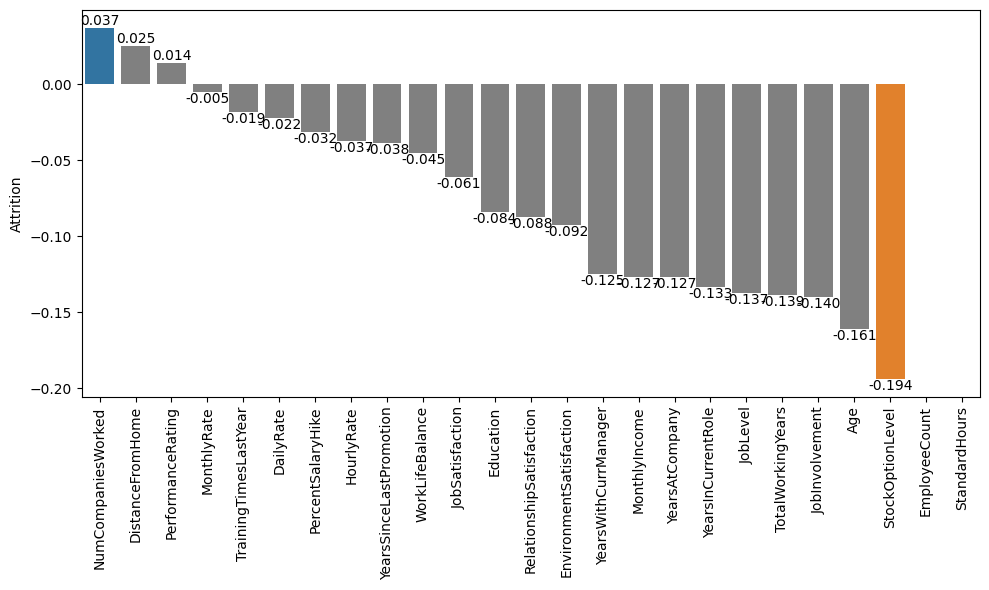

In [17]:
# explore correlation between each column and attrition
attrition_corr = pd.concat([df_num,df['Attrition']],axis=1).corr().iloc[:-1,-1].sort_values(ascending = False)
cols = ['#ff7f0e' if (x == min(attrition_corr)) else ('#1f77b4' if (x == max(attrition_corr)) else 'grey') for x in attrition_corr]

plt.figure(figsize=(10,6))
ax = sns.barplot(x=attrition_corr.index,y=attrition_corr,palette=cols)
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.xticks(rotation=90)

plt.tight_layout()

## Categorical Features

In [18]:
# create a dataframe containing only categorical columns from the original dataframe
df_cat = df.select_dtypes('object')
df_cat.shape

(1677, 8)

In [19]:
# explore how the number of unique values and value counts in each column
for col in df_cat.columns:
    print(col)
    print(df_cat[col].value_counts())
    print('--'*20)

BusinessTravel
Travel_Rarely        1290
Travel_Frequently     261
Non-Travel            126
Name: BusinessTravel, dtype: int64
----------------------------------------
Department
Research & Development    1167
Sales                      471
Human Resources             39
Name: Department, dtype: int64
----------------------------------------
EducationField
Life Sciences       775
Medical             549
Marketing           152
Technical Degree    106
Other                82
Human Resources      13
Name: EducationField, dtype: int64
----------------------------------------
Gender
Male      1064
Female     613
Name: Gender, dtype: int64
----------------------------------------
JobRole
Sales Executive              355
Research Scientist           344
Laboratory Technician        334
Manufacturing Director       196
Healthcare Representative    155
Manager                      111
Sales Representative          77
Research Director             71
Human Resources               34
Name: JobR

-> **unecessary categorical column** ('Over18'): cotains only one value<br>
-> **ordinal categorical column** ('Business Travel'): contains ordinal values

In [20]:
# function that prevents tick labels to be overlapped in chart
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

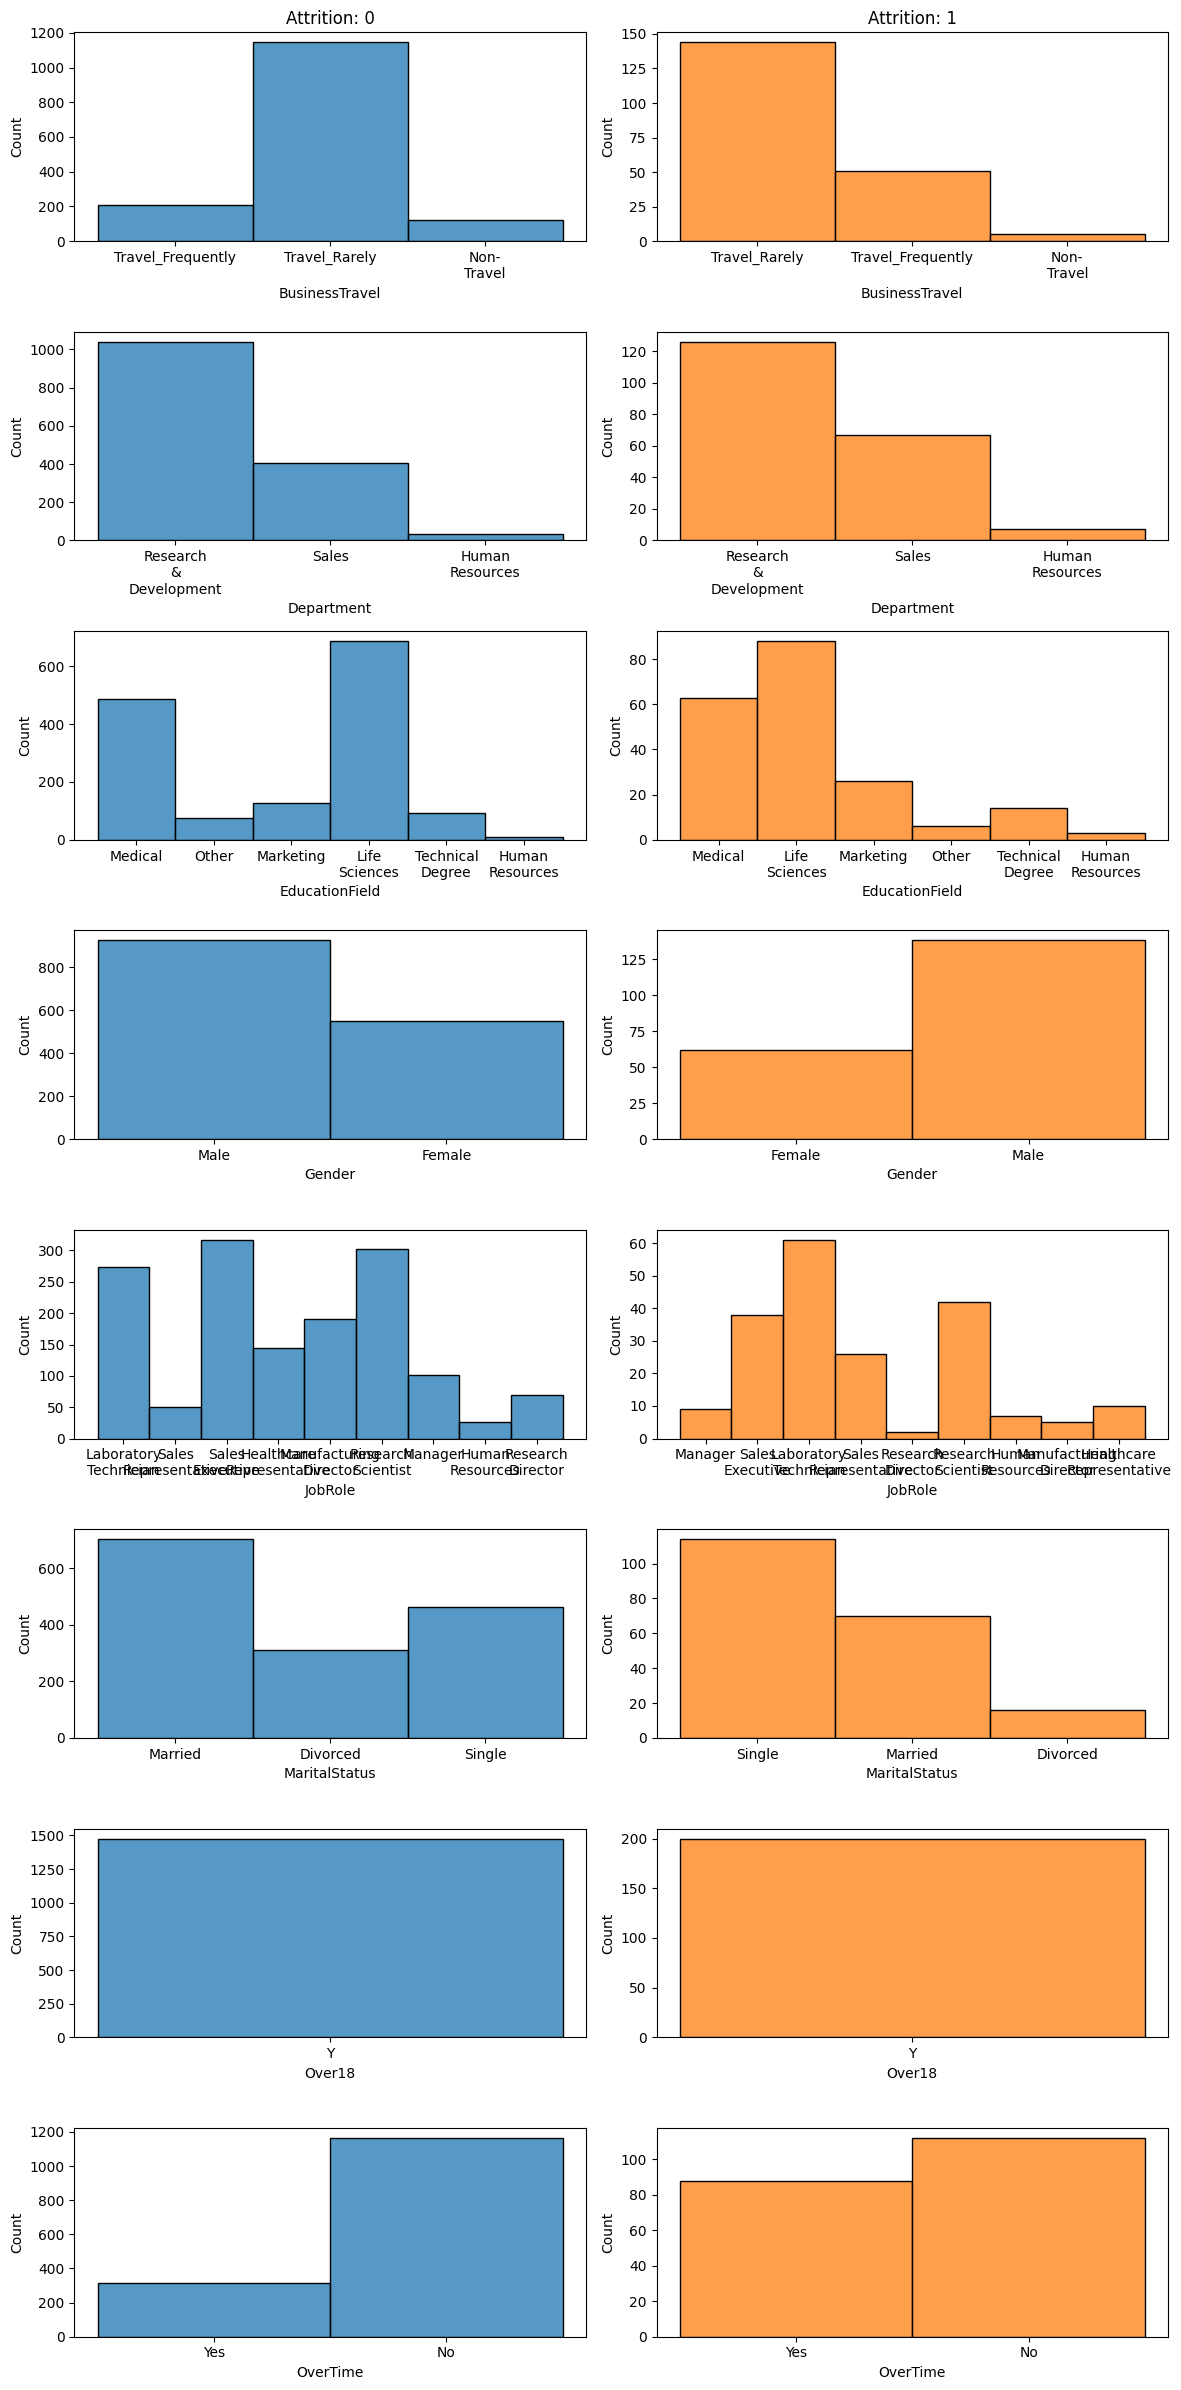

In [21]:
# visualize distribution of values in categorical columns group by Attrition
ncols = 2
nrows = len(df_cat.columns)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,nrows*3))

axs[0,0].set_title('Attrition: 0')
for col, ax in zip(df_cat.columns, axs[:,0]):
    sns.histplot(data=pd.concat([df_cat,df['Attrition'].astype('category')],axis=1)[df['Attrition']==0],x=col,color='#1f77b4',ax=ax)
    wrap_labels(ax, 2)
    
axs[0,1].set_title('Attrition: 1')
for col, ax in zip(df_cat.columns, axs[:,1]):
    sns.histplot(data=pd.concat([df_cat,df['Attrition'].astype('category')],axis=1)[df['Attrition']==1],x=col,color='#ff7f0e',ax=ax)
    wrap_labels(ax, 2)

plt.tight_layout()

# Data Preprocessing

In [22]:
train_df = df.copy()
test_df = pd.read_csv('/kaggle/input/playground-series-s3e3/test.csv',index_col=0)

In [23]:
# drop unecessary columns detected through EDA
train_df.drop(['EmployeeCount','StandardHours','Over18'],axis=1,inplace=True) # columns cotaining only one value
train_df.drop(['JobLevel','TotalWorkingYears','PercentSalaryHike','YearsInCurrentRole','YearsWithCurrManager'],axis=1,inplace=True) # columns showing high correlation with other columns

test_df.drop(['EmployeeCount','StandardHours','Over18'],axis=1,inplace=True) 
test_df.drop(['JobLevel','TotalWorkingYears','PercentSalaryHike','YearsInCurrentRole','YearsWithCurrManager'],axis=1,inplace=True) 

In [24]:
# standardize values in numerical columns
train_num = train_df.drop('Attrition',axis=1).select_dtypes('number')

sc = StandardScaler()

train_df[train_num.columns] = pd.DataFrame(sc.fit_transform(train_num),columns=train_num.columns)

In [25]:
# convert 'Business Travel' to numerical values using ordinality of categories
numeric_var = {'Travel_Frequently':3, 'Travel_Rarely':2, 'Non-Travel':1}

train_df['BusinessTravel'].replace(numeric_var,inplace=True)
test_df['BusinessTravel'].replace(numeric_var,inplace=True)

In [26]:
# one hot encode categorical columns
train_df = pd.get_dummies(train_df,drop_first=True)
test_df = pd.get_dummies(test_df,drop_first=True)

In [27]:
# remove outliers
# tran_df = [(np.abs(stats.zscore(train_df)) < 5).all(axis=1)]

In [28]:
# resample examples to resolve class imbalance
X = train_df.drop('Attrition',axis=1)
y = train_df['Attrition']

X, y = SMOTE(sampling_strategy=1, random_state=0).fit_resample(X, y)

# Models

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
predictions = lg.predict(X_test)
accuracy_score(predictions, y_test)

0.884102564102564

In [31]:
# define models and parameters
logistic_model = LogisticRegression()
logistic_grid = {
    'solver' : ['lbfgs','newton-cg', 'sag', 'saga'],
    'penalty' : ['l1', 'l2', 'elasticnet', None],
    'C' : [100, 10, 1.0, 0.1, 0.01],
}

KNN_model = KNeighborsClassifier()
KNN_grid = {
    'n_neighbors' : range(1,21,2),
    'weights' : ['uniform','distance'],
    'p' : np.arange(1,2,0.10)
} 

SVM_model = SVC()
SVM_grid = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : [0.01, 0.1, 1, 10, 100],
    'gamma' : ['scale', 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
}

RF_model = RandomForestClassifier()
RF_grid = {
    'n_estimators' : [25, 50, 100, 150],
    'max_features' :  ['sqrt', 'log2', None],
    'max_depth' : [3, 6, 9],
    'max_leaf_nodes' : [3, 6, 9]
}


lst = [(logistic_model, logistic_grid),
       (KNN_model, KNN_grid),
       (RF_model, RF_grid)]

In [32]:
# results
for model, grid in lst:
    # define grid search
    grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy')
    grid_result = grid_search.fit(X_train, y_train)
    estimator = grid_result.best_estimator_
    predictions = estimator.predict(X_test)
    
    # print out best score and best estimator ofr the model
    print('Best score on Gridsearch: ', grid_result.best_score_)
    print('Using: ', estimator)
    print('\n')
    
    # print out classification report on test data for each model
    print(classification_report(predictions, y_test))
    print('Accuracy Score: ', accuracy_score(predictions, y_test))
    print('--'*40)

Best score on Gridsearch:  0.8807658867152538
Using:  LogisticRegression(C=100, penalty='l1', solver='saga')


              precision    recall  f1-score   support

           0       0.88      0.89      0.89       491
           1       0.89      0.88      0.88       484

    accuracy                           0.89       975
   macro avg       0.89      0.89      0.89       975
weighted avg       0.89      0.89      0.89       975

Accuracy Score:  0.8851282051282051
--------------------------------------------------------------------------------
Best score on Gridsearch:  0.8964032732387164
Using:  KNeighborsClassifier(n_neighbors=1, p=1.0)


              precision    recall  f1-score   support

           0       0.77      1.00      0.87       382
           1       1.00      0.81      0.89       593

    accuracy                           0.88       975
   macro avg       0.88      0.90      0.88       975
weighted avg       0.91      0.88      0.88       975

Accuracy Score:  0.

# Prediction

In [33]:
test_df.isna().sum()

Age                                  0
BusinessTravel                       0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EnvironmentSatisfaction              0
HourlyRate                           0
JobInvolvement                       0
JobSatisfaction                      0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
PerformanceRating                    0
RelationshipSatisfaction             0
StockOptionLevel                     0
TrainingTimesLastYear                0
WorkLifeBalance                      0
YearsAtCompany                       0
YearsSinceLastPromotion              0
Department_Research & Development    0
Department_Sales                     0
EducationField_Life Sciences         0
EducationField_Marketing             0
EducationField_Medical               0
EducationField_Other                 0
EducationField_Technical 

In [34]:
final_model = LogisticRegression(C=100, penalty='l1', solver='saga')
final_model.fit(X_train,y_train)
final_prediction = final_model.predict(test_df)

In [35]:
# convert prediction into dataframe
outcome_df = pd.DataFrame({"id": test_df.index,"Attrition": final_prediction})

# export as csv file
outcome_df.to_csv("submission.csv",index = False)